In [54]:
import pandas as pd
from pandas import rolling_median
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set() # setting seaborn default for plots

import helpers

# Manipulando Dados

O objetivo da atividade é exercitar a manipulação e preprocessamento de uma base de dados e utiliza-la num algoritmo de aprendizagem de máquina, como exemplo é utilizada a base de dados de passageiros do Titanic.


## Leitura dos dados

In [55]:
df = pd.read_csv('dataset/train.csv')
df.columns = map(str.lower, df.columns)

print(len(df))

df[:10]

891


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 1 - Pré-processamento dos dados

Foram aplicados alguns passo de pré-processamento dos dados que são descutidos a seguir

## 1.5 - Identificação e remoção de valores discrepantes

Nesse passo são verificados os dados da coluna 'Fare' a fim de identificar dados com valores discrepantes em relação aos demais. São utilizadas a média e o desvio padrão dos dados para a indeficação dos valores discrepantes 

### Distribuição dos dados antes da remoção dos valores discrepantes 

891

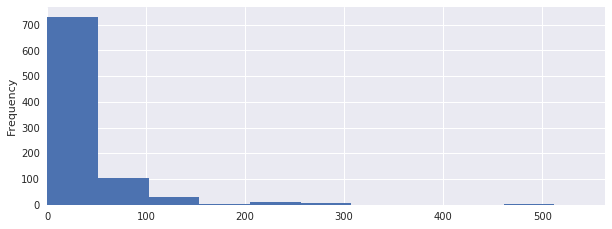

In [56]:
df = helpers.drop_nan_row(df, 'fare')
helpers.plot_dist(df, 'fare', 'hist')

len(df)

### Distribuição dos dados após a remoção dos valores discrepantes

853

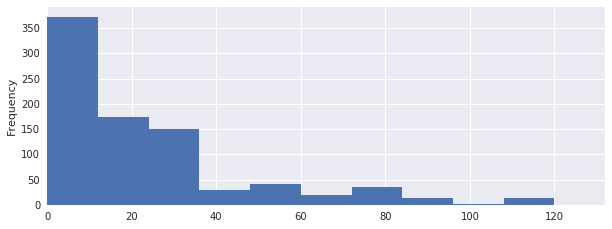

In [57]:
df = helpers.remove_outliers(df, "fare", 2)

helpers.plot_dist(df, 'fare', 'hist')

len(df)

## 1.2 Remoção de atributos

Alguns atributos dos dados foram desconsiderados, como: 'Ticket', 'Cabin', entre outros, por conterem informações que consideramos desnecessárias ou por muitas informações inexistentes. 

## 1.3 Substituição de dados faltantes

Alguns dados possuem apenas alguns atributos com valor inexistente, por exemplo, apenas algumas linha não possuem o atributo 'Age', nesses casos foram atribuídos a média dos valores de todo o conjunto de dadosções

## 1.4 Conversão de dados

Algumas informações não estão em valor numérico, como 'Sex', 'Name' e 'Embarked', nesses casos, a strings foram consideradas como classes e essas classes foram utilizadas no lugar do valor original, por exemplo, os valore 'male' e 'female' são subistituídas pelos valores 0 e 1, respectivamente, que representam as 'classes' dos valores.

## 1.5 Normalização de dados

Foi feita uma normalização nos valores dos atributos para que a variação entre os valores seja menor, o que ajudará na utilização dos dados para o treinamento.

In [58]:
df = helpers.titanic_preprocessing_pipeline(df, 'standard')

print(len(df))

df[:10]

851


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,0,0.783177,0.405725,0.711474,-0.572650,0.433001,-0.456159,-0.701453,0.572265
1,1,-1.703703,0.946903,-1.405534,0.665935,0.433001,-0.456159,2.000742,-2.011278
2,1,0.783177,-1.217810,-1.405534,-0.263004,-0.467937,-0.456159,-0.672968,0.572265
3,1,-1.703703,0.946903,-1.405534,0.433700,0.433001,-0.456159,1.233410,0.572265
4,0,0.783177,0.405725,0.711474,0.433700,-0.467937,-0.456159,-0.667693,0.572265
5,0,0.783177,0.405725,0.711474,-0.030769,-0.467937,-0.456159,-0.650463,-0.719506
6,0,-1.703703,0.405725,0.711474,1.904520,-0.467937,-0.456159,1.181187,0.572265
7,0,0.783177,-1.758988,0.711474,-2.120881,2.234877,0.808308,-0.118040,0.572265
8,1,0.783177,0.946903,-1.405534,-0.185592,-0.467937,2.072774,-0.537578,0.572265
9,1,-0.460263,0.946903,-1.405534,-1.191942,0.433001,-0.456159,0.261581,-2.011278


## 2 - Correlação dos dados

Abaixo é apresentada a matriz de correlação dos atributos, isso é feito para se buscar por atributos com correlações fortes afim de eliminar um deles.

Na matriz de correlações dos dados trabalhados, a maior correção, em módulo, é entre 'Pclass' e 'Fate', com um correlação de aproximadamente '-0.65', o que não consideramos uma correlação suficientemente forte para eliminar um dos atributos.

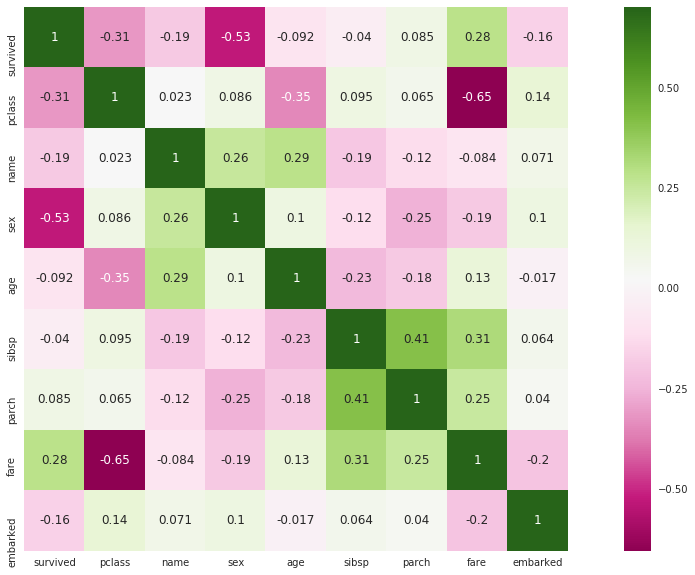

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), vmax=0.7, square=True, annot=True, cmap="PiYG")

## 3 Utilizando os dados no treinamento

Os modelos de redes neurais seguem a base:

**Camadas** - 5

**Camadas ocultas** - 3

- **Camada 1**:
    - **in**: 8
    - **out**: 10
    - **Função de Ativação**: Tanh
- **Camada 2**:
    - **in**: 10
    - **out**: 20
    - **Função de Ativação**: Tanh
- **Camada 3**:
    - **in**: 20
    - **out**: 30
    - **Função de Ativação**: Tanh
- **Camada 4**:
    - **in**: 30
    - **out**: 30
    - **Função de Ativação**: Tanh
- **Camada 5**:
    - **in**: 30
    - **out**: 1
    - **Função de Ativação**: Sigmoid

A arquitura é baseada na arquitetura apresenta nesse [artigo](https://medium.com/clusterone/tensorflow-beginner-guide-titanic-dataset-clusterone-7c134e447f3c) onde são utilizadas 3 camadas ocultas de tamanho 20 e utilizando a função de ativação Tangente Hiperbólica.

In [60]:
data_train = df.copy(deep=True)

data_test = pd.read_excel('dataset/titanic3.xls', sheet_name="titanic3")
data_test.columns = [x.lower() for x in data_test.columns]
data_test = helpers.titanic_preprocessing_pipeline(data_test, 'standard')

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [61]:
y_train = data_train['survived'].values
data_train = data_train.drop(['survived'], axis=1)
x_train = data_train.values

y_test = data_test['survived'].values
data_test = data_test.drop(['survived'], axis=1)
x_test = data_test.values

In [62]:
y_train.shape

(851,)

## 3.1.1 Validação Cruzada (k-fold)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_69 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_70 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_71 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 31        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________


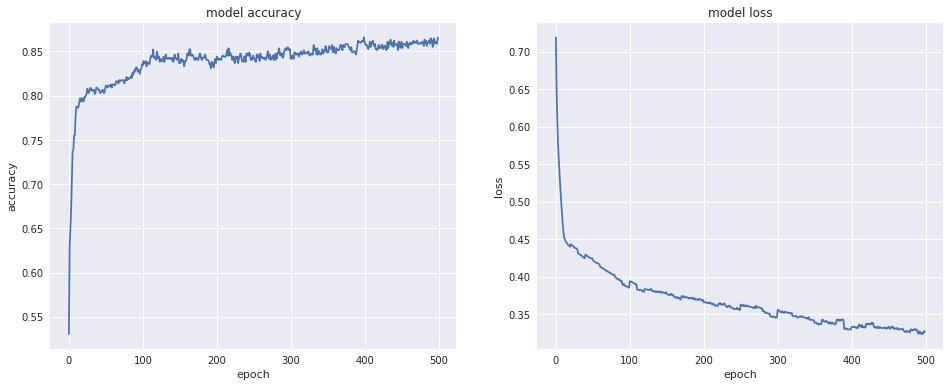

In [63]:
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []
loss_track = []

for train, test in kfold.split(x_train, y_train):
    history = model.fit(x_train[train], y_train[train], epochs=10, batch_size=100, verbose=0, shuffle=True,
                  validation_data=(x_train[test], y_train[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)


helpers.plot_acc_loss(acc_track, loss_track)

Accuracy: 82.312%


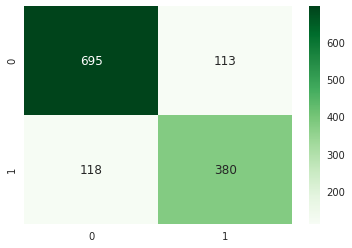

In [64]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.1.2 Validação Cruzada (k-fold) + Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_74 (Dense)             (None, 10)                90        
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 20)                220       
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_18 (Dropout)         (None, 30)                0         
__________

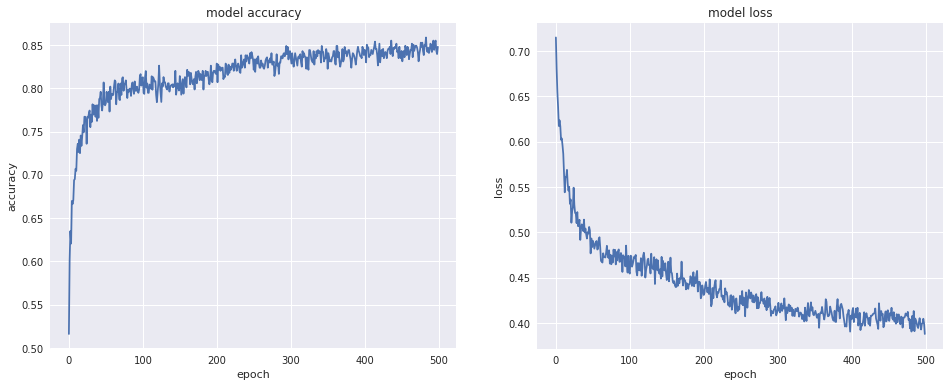

In [65]:
kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(20, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(30, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []
loss_track = []

for train, test in kfold.split(x_train, y_train):
    history = model.fit(x_train[train], y_train[train], epochs=10, batch_size=100, verbose=0, shuffle=True,
                  validation_data=(x_train[test], y_train[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)


helpers.plot_acc_loss(acc_track, loss_track)

Accuracy: 81.317%


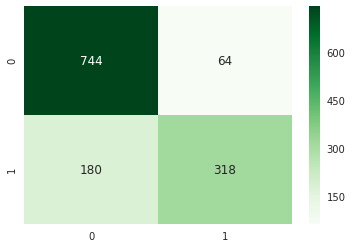

In [67]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.1.3 Validação Cruzada (k-fold) + Normalização de Batch

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_79 (Dense)             (None, 10)                90        
_________________________________________________________________
batch_normalization_17 (Batc (None, 10)                40        
_________________________________________________________________
dense_80 (Dense)             (None, 20)                220       
_________________________________________________________________
batch_normalization_18 (Batc (None, 20)                80        
_________________________________________________________________
dense_81 (Dense)             (None, 30)                630       
_________________________________________________________________
batch_normalization_19 (Batc (None, 30)                120       
__________

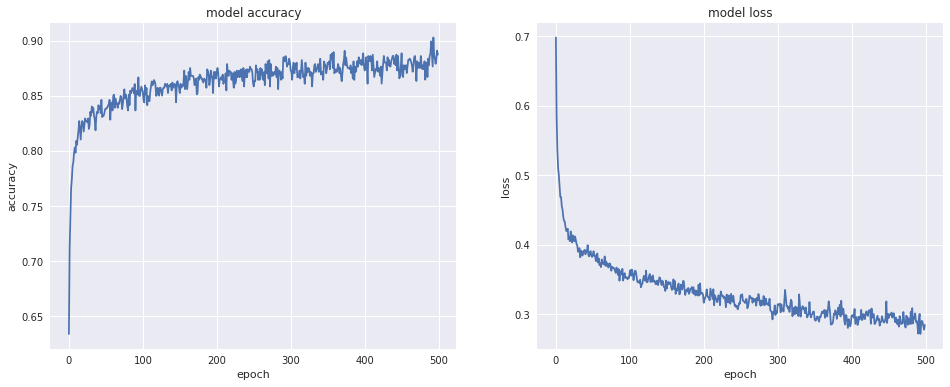

In [68]:
kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(20, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(30, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []
loss_track = []

for train, test in kfold.split(x_train, y_train):
    history = model.fit(x_train[train], y_train[train], epochs=10, batch_size=100, verbose=0, shuffle=True,
                  validation_data=(x_train[test], y_train[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)


helpers.plot_acc_loss(acc_track, loss_track)

Accuracy: 80.781%


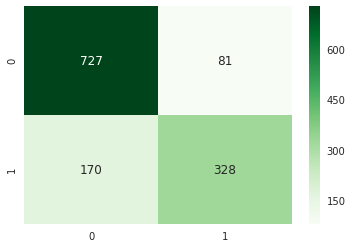

In [69]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.1.3 Validação Cruzada (k-fold) + Normalização de Batch + Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_84 (Dense)             (None, 10)                90        
_________________________________________________________________
batch_normalization_20 (Batc (None, 10)                40        
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 20)                220       
_________________________________________________________________
batch_normalization_21 (Batc (None, 20)                80        
_________________________________________________________________
dropout_20 (Dropout)         (None, 20)                0         
__________

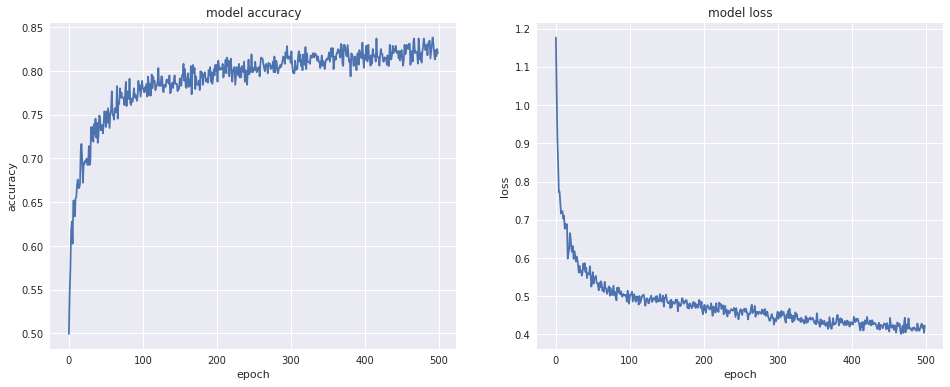

In [70]:
kfold = StratifiedKFold(n_splits=50, shuffle=True, random_state=seed)

model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(20, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(30, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []
loss_track = []

for train, test in kfold.split(x_train, y_train):
    history = model.fit(x_train[train], y_train[train], epochs=10, batch_size=100, verbose=0, shuffle=True,
                  validation_data=(x_train[test], y_train[test]))

    for acc, loss in zip(history.history['acc'], history.history['loss']):
        acc_track.append(acc)
        loss_track.append(loss)


helpers.plot_acc_loss(acc_track, loss_track)

Accuracy: 81.700%


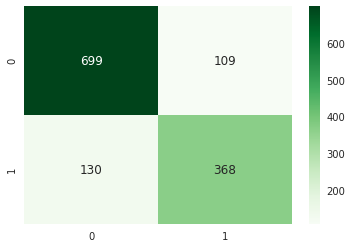

In [71]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.2.1 Holdout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_89 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_90 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_91 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 31        
Total params: 1,043
Trainable params: 1,043
Non-trainable params: 0
_________________________________________________________________


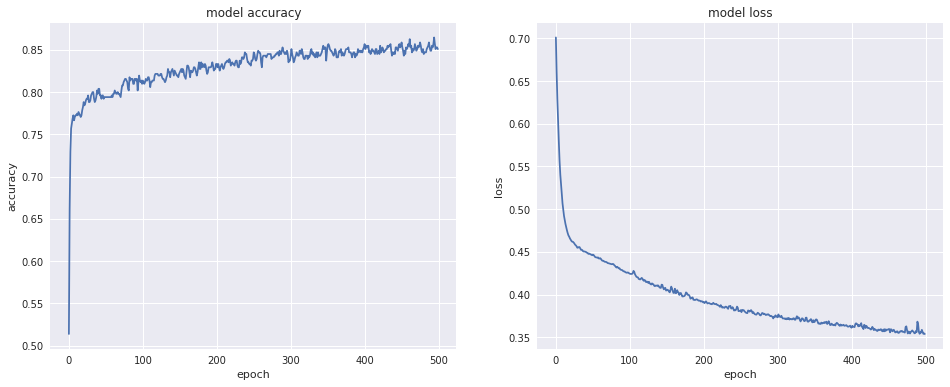

In [72]:
model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

history = model.fit(x_train, y_train, epochs=500, batch_size=100, verbose=0, shuffle=True, validation_split=0.4)

helpers.plot_acc_loss(history.history['acc'], history.history['loss'])

Accuracy: 80.858%


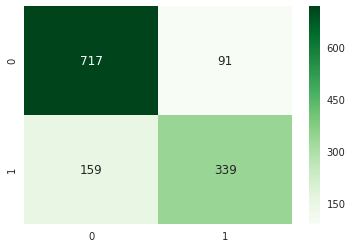

In [73]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.2.2 Holdut + Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_94 (Dense)             (None, 10)                90        
_________________________________________________________________
dropout_22 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 20)                220       
_________________________________________________________________
dropout_23 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 30)                630       
_________________________________________________________________
dropout_24 (Dropout)         (None, 30)                0         
__________

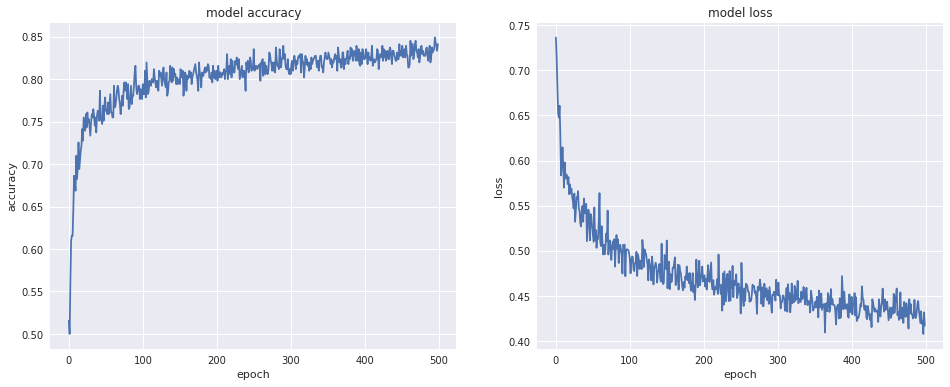

In [74]:
model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(20, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(30, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

history = model.fit(x_train, y_train, epochs=500, batch_size=100, verbose=0, shuffle=True, validation_split=0.4)

helpers.plot_acc_loss(history.history['acc'], history.history['loss'])

Accuracy: 81.394%


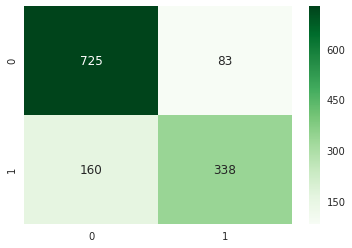

In [75]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.2.3 Holdout + Normalização de Batch

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_99 (Dense)             (None, 10)                90        
_________________________________________________________________
batch_normalization_23 (Batc (None, 10)                40        
_________________________________________________________________
dense_100 (Dense)            (None, 20)                220       
_________________________________________________________________
batch_normalization_24 (Batc (None, 20)                80        
_________________________________________________________________
dense_101 (Dense)            (None, 30)                630       
_________________________________________________________________
batch_normalization_25 (Batc (None, 30)                120       
__________

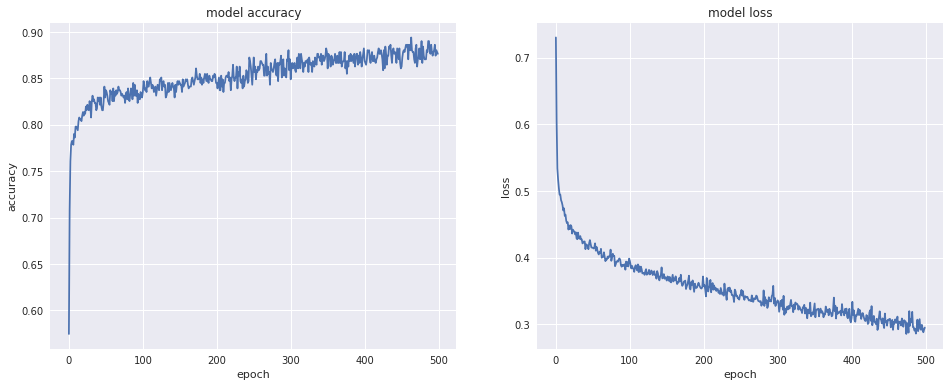

In [76]:
model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(20, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(30, activation='tanh'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

history = model.fit(x_train, y_train, epochs=500, batch_size=100, verbose=0, shuffle=True, validation_split=0.4)

helpers.plot_acc_loss(history.history['acc'], history.history['loss'])

Accuracy: 80.092%


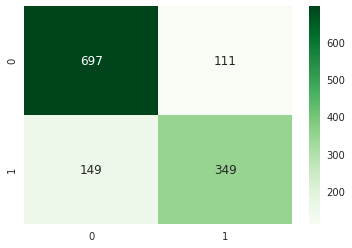

In [77]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 3.2.3 Holdout + Normalização de Batch + Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_104 (Dense)            (None, 10)                90        
_________________________________________________________________
batch_normalization_26 (Batc (None, 10)                40        
_________________________________________________________________
dropout_25 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 20)                220       
_________________________________________________________________
batch_normalization_27 (Batc (None, 20)                80        
_________________________________________________________________
dropout_26 (Dropout)         (None, 20)                0         
__________

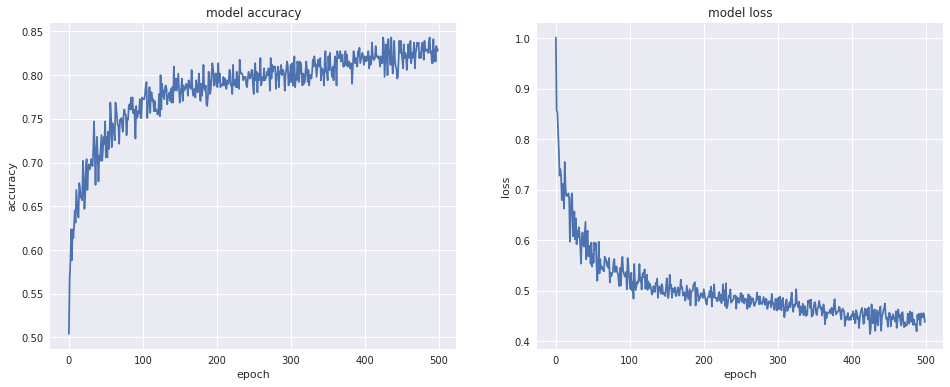

In [78]:
model = Sequential()
model.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='tanh'))

model.add(Dense(10, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(20, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(30, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

acc_track = []

history = model.fit(x_train, y_train, epochs=500, batch_size=100, verbose=0, shuffle=True, validation_split=0.4)

helpers.plot_acc_loss(history.history['acc'], history.history['loss'])

Accuracy: 79.862%


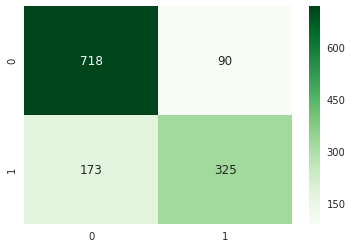

In [79]:
y_pred = np.round(model.predict(x_test)).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print('Accuracy: {0:.3f}%'.format(acc*100))

plt.subplot(111)
sns.heatmap(matrix, annot=True, fmt='d', cmap="Greens")

## 4 Comparação

|x        |K-Fold     | Holdout |
|---------|-----------|---------|
|*        |82.312%    |79.862%  |
|Dropout  |81.317%    |81.394%  |
|Norm. Batch|80.781%  |79.250%  |
|Drpout + Norm. Batch|81.700%|80.704%|

## 5 Referências

https://github.com/ramansah/kaggle-titanic/blob/master/Analysis.ipynb

https://www.kaggle.com/chapagain/titanic-solution-a-beginner-s-guide

https://blog.socialcops.com/engineering/machine-learning-python/

https://medium.com/clusterone/tensorflow-beginner-guide-titanic-dataset-clusterone-7c134e447f3c